In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import itertools
import numpy   as     np
from   numba   import njit
from   os.path import join
from   src_dir import Gauss_pdf_2D, GMRES, GMRES_numba, mk_laplace_2d, laplace_2d_dirichlet, laplace_2d_extrap, laplace_2d_constextrap

In [4]:
# Set dimension of the NxN grid used
# Note: For optimal performance, the neural network "cnn_collectionOnline2D.py"
# can be tweaked with appropriate kernel dilations, however the code should
# still work and yield resuluts for any dimension of input provided
dim = 40

# Default initial guess used for direct un-preconditioned GMRES is the zero
# solution
x0 = np.squeeze(np.zeros((dim,dim)))

# Set tolerances for GMRES solver
e = 1e-5

# Restarted GMRES parameters
nmax_iter = int(dim/5)
restart   = 10000

# Create domain [-1,1]x[-1,1]
# Define grid values at midpoints of cartesian grid
DomainL = -1.0
DomainR =  1.0
dx = (DomainR-DomainL)/(dim-1)
x1 = np.linspace(DomainL+dx,DomainR-dx,dim)
x2 = np.linspace(DomainL+dx,DomainR-dx,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')
Area = (dx*(dim-1))**2

# Create 2D laplace opertor as a stencil opertor for a N-cell 2D grid
# Can be found in linop.py in src_di
@njit(nogil=True)
def A_numba(x):
    return laplace_2d_constextrap(x)
AType = '2D Laplacian'

# Uniform time-step used
dt = 0.0001
n_steps = 10000

In [5]:
def particle(X, Y, x, y, charge, sigma):
    b = charge*Gauss_pdf_2D(X, Y, x, y, sigma)
    return b

def force(dx, X, Y, phi_x, phi_y, x, y,sigma):
    weights = Gauss_pdf_2D(X, Y, x, y, sigma)
    return np.array([
        np.sum(phi_x*weights),
        np.sum(phi_y*weights)
    ])*dx**2

In [6]:
from src_dir import cnn_preconditionerOnline_timed_2D, CNNPredictorOnline_2D,\
                    timer, GMRES, PreconditionerTrainer, FluidNet2D30

# Note: # Model dimention inputs are not used for the current network in cnn_predictorOnline2D.py (but must be passed into wrapper)
InputDim  = dim
OutputDim = dim
# Number of samples to collect before using preduction from Neural Network:
Initial_set = 100

nn_precon = CNNPredictorOnline_2D(InputDim, OutputDim, Area, dx, FluidNet2D30)
# TODO: using diagnostic_probe=10 => end of first inner loop for the current setup => generalize this
trainer   = PreconditionerTrainer(nn_precon, Initial_set=Initial_set, diagnostic_probe=22)

@timer
@cnn_preconditionerOnline_timed_2D(trainer)
def MLGMRES(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES_numba(A, b, x0, e, nmax_iter, restart, debug)

@timer
def GMRES_timed(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES_numba(A, b, x0, e, nmax_iter, restart, debug)

In [7]:
def time_step(mot, dt, dx, X, Y, p_0, p_lo, p_hi, charge, sigma):
    b = particle(X, Y, *p_0[0, :], charge[0], sigma)
    for i in range(1, len(charge)):
        b += particle(X, Y, *p_0[i, :], charge[i], sigma)
    
    Out = GMRES_numba(A_numba, b, x0, e, nmax_iter, restart, True)
    phi = Out[-1]
    # this is pretty powerful: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    phi_x, phi_y = np.gradient(phi)
    
    p_1 = np.zeros_like(p_0)
    for i in range(1, len(charge)):
        p_1[i, :] = p_0[i, :] + mot*dt*charge[i]*force(dx, X, Y, phi_x, phi_y, *p_0[i,:], sigma)
        if p_1[i, 0] < p_lo:
            p_1[i, 0] = p_lo
        if p_1[i, 0] > p_hi:
            p_1[i, 0] = p_hi
        if p_1[i, 1] < p_lo:
            p_1[i, 1] = p_lo
        if p_1[i, 1] > p_hi:
            p_1[i, 1] = p_hi
    
    return p_1, b, phi, phi_x, phi_y

In [8]:
def time_step_timed(sol_fn, mot, dt, dx, X, Y, p_0, p_lo, p_hi, charge, sigma):
    b = particle(X, Y, *p_0[0, :], charge[0], sigma)
    for i in range(1, len(charge)):
        b += particle(X, Y, *p_0[i, :], charge[i], sigma)
    
    Out, run_time = sol_fn(A_numba, b, x0, e, nmax_iter, restart, True)
    phi = Out[-1]
    # this is pretty powerful: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    phi_x, phi_y = np.gradient(phi)
    
    p_1 = np.zeros_like(p_0)
    for i in range(1, len(charge)):
        p_1[i, :] = p_0[i, :] + mot*dt*charge[i]*force(dx, X, Y, phi_x, phi_y, *p_0[i,:], sigma)
        if p_1[i, 0] < p_lo:
            p_1[i, 0] = p_lo
        if p_1[i, 0] > p_hi:
            p_1[i, 0] = p_hi
        if p_1[i, 1] < p_lo:
            p_1[i, 1] = p_lo
        if p_1[i, 1] > p_hi:
            p_1[i, 1] = p_hi
    
    return p_1, b, phi, phi_x, phi_y, Out, run_time

In [9]:
p_0 = np.array(
    [[0, 0],
     [-0.6, 0.6],
     [0.1, -0.5],
     [0.2, 0.5],
     [-0.1, 0.5],
     [-0.2, -0.5],
     [0.6, -0.6],
     [0.6, -0.2],
     [-0.75, -.25],
     [0.75, 0.75],
     [-0.25, 0.25],
     [0., 0.75],
     [-0.75, 0],
     [-0.75, -0.75]]
)
charge = np.array(
    [ 1,
     -1,
      1,
     -1,
     -1,
      1,
     -1,
      1,
      1,
     -1,
     -1,
      1,
      1,
     -1]
)

In [10]:
p_lo = DomainL
p_hi = DomainR

In [11]:
p_1, b_1, phi, phi_x, phi_y, Out, run_time = time_step_timed(GMRES_timed, 0.5, 0, dx, X, Y, p_0, p_lo, p_hi, charge, 0.05)

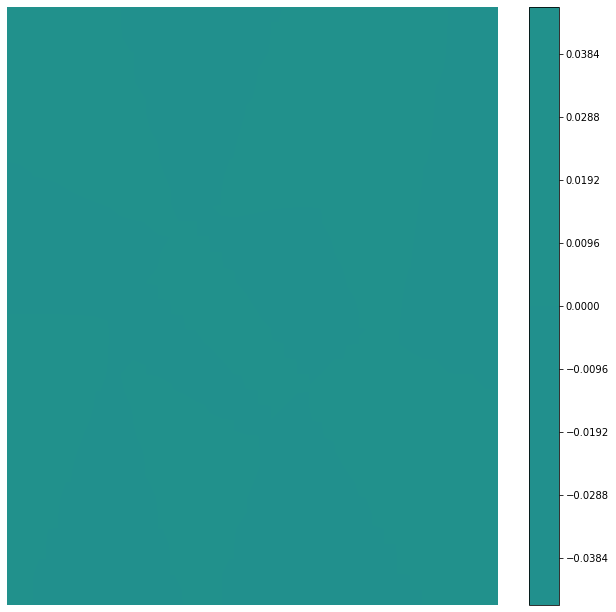

In [28]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, b_1, levels=160, vmin=-60, vmax=60)
colorbar(cp)
axis("off");

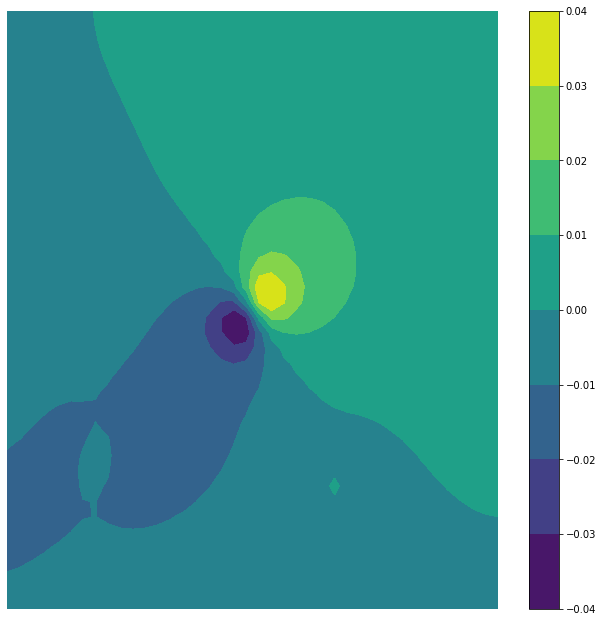

In [29]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, phi)
colorbar(cp)
axis("off");

In [14]:
from src_dir import Gauss_pdf_2D, resid, StatusPrinter

#Set the numpy seed
np.random.seed(0)

# Initialize lists that hold time data (time-to-solutuin, trainining time,
# MLGMRES time, etc)
run_time_ML_list     = []
GmresRunTimeOriginal = []
SpeedUp              = []
trainTime_list       = []

# Set debug mode (prints more information to screen)
debug = True

NonML_Err_List      = []
NonML_Err_List_Full = []

# Initial condition and initial time
t = dt

# Index of  Poisson problems solved
for ProbIdx in range(n_steps):

    # First GMRES call (solve up to e1 tolerance) with ML wrapper
    trainer.ProbCount = ProbIdx  # TODO: This should probably be automatically incremented
    p_1, b_1, phi, phi_x, phi_y, Out, run_time1_ML = time_step_timed(
        MLGMRES, 0.05, dt, dx, X, Y, p_0, p_lo, p_hi, charge, 0.05
    )
    # Out, run_time1_ML = MLGMRES(A, b, x0, e, nmax_iter, restart, debug)

    # Collect ML assisted Run-times
    run_time_ML_list.append(run_time1_ML)
    if len(trainer.trainTime) > 0:
        trainTime_list.append(trainer.trainTime[-1]) # TODO: this second list is not needed
    
    # Direct GMRES call up to e1 tolerance
    _, _, _, _, _, NonML_Out1, run_time1 = time_step_timed(
        GMRES_timed, 0.05, 0, dx, X, Y, p_0, p_lo, p_hi, charge, 0.05
    )
    # NonML_Out1, run_time1 = GMRES_timed(A, b, x0, e, nmax_iter, restart, debug)  
    NonML_Err = resid(A_numba, NonML_Out1, b_1)
    NonML_Err_List_Full.append(NonML_Err)
    NonML_Err_List.append(NonML_Err[3])
    ## Collect  direct GMRES timeHeatSource
    GmresRunTimeOriginal.append(run_time1)

    ## Ratio of run-timesHeatSource
    SpeedUp.append(run_time1/trainer.ML_GMRES_Time_list[-1])

    # Update user on status
    StatusPrinter().update_simulation(SpeedUp[-1], ProbIdx)

    # Next time step
    t = t + dt
    p_0 = p_1

StatusPrinter().finalize()


MLGMRES_GMRES_ONLY = sum(trainer.ML_GMRES_Time_list)
run_time           = sum(GmresRunTimeOriginal)
run_time_ML        = sum(run_time_ML_list)
trainTime_total    = sum(trainTime_list)

print("Runtime of Non-decorated version is: ",     run_time)
print("Runtime of MLGMRES decorator is: ",         run_time_ML)
print("Runtime of MLGMRES (only GMRES time) is: ", MLGMRES_GMRES_ONLY)
print("Runtime of training (backprop) is: ",       trainTime_total)

/Users/blaschke/local/virtualenv/py3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


/Users/blaschke/local/virtualenv/py3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


iter=9999 speedup=1.0006 loss=4.9916e-04 parameters=13883 data size=377
Runtime of Non-decorated version is:  291.12769723413805
Runtime of MLGMRES decorator is:  21760.254087677975
Runtime of MLGMRES (only GMRES time) is:  200.2840000630274
Runtime of training (backprop) is:  765825.4160220025


In [15]:
from src_dir import moving_average

# Compute moving average of GMRES and MLGMRES error
AVG   = np.zeros((n_steps, 1))
count = np.arange(0, n_steps)

Err_Array = np.asarray(NonML_Err_List)
count     = np.arange(0, n_steps)
for j in range(0, n_steps):
    AVG[j] = moving_average(np.asarray(Err_Array[:j]), j)

Err_Array_ML = np.asarray(trainer.Err_list)
AVGML        = np.zeros((n_steps, 1))
for j in range(0, n_steps):
    AVGML[j] = moving_average(np.asarray(Err_Array_ML[:j]), j)    

# Compute moving average of GMRES and MLGMRES run-times
GmresRunTimeOriginal_AVG = np.zeros((n_steps, 1))
ML_GMRES_Time_AVG        = np.zeros((n_steps, 1))

for j in range(0, n_steps):
    GmresRunTimeOriginal_AVG[j] = moving_average(np.asarray(GmresRunTimeOriginal[:j]), j)

for j in range(0, n_steps):
    ML_GMRES_Time_AVG[j] = moving_average(np.asarray(trainer.ML_GMRES_Time_list[:j]), j)

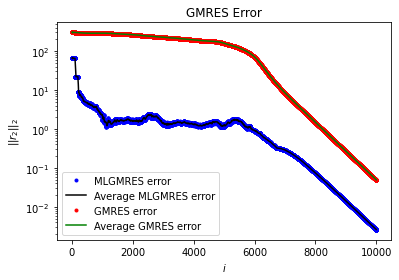

In [30]:
plot(count,Err_Array_ML,'.b',label='MLGMRES error')
plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
plot(count,Err_Array,'.r',label='GMRES error')
plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

title('GMRES Error')
xlabel('$i$')
ylabel('$||r_2||_2$')
legend(loc='best')
yscale("log")
# pp.savefig('AdvectDiff_Error.png')

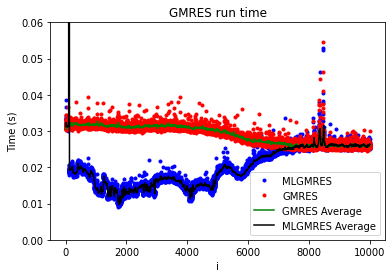

In [25]:
plot(trainer.ML_GMRES_Time_list,'.b',label='MLGMRES')
plot(GmresRunTimeOriginal,'.r', label='GMRES')
plot(count[20:-1],GmresRunTimeOriginal_AVG[20:-1],'g', label='GMRES Average')
plot(count[20:-1],ML_GMRES_Time_AVG[20:-1],'k', label='MLGMRES Average')

ylim(0, 0.06)

ylabel('Time (s)')
xlabel('i')
title('GMRES run time')
legend(loc='best')
# pp.savefig('AdvectDiff_time.png')

Text(0.5, 1.0, 'Convergence of Algorithim for Final Linear Problem')

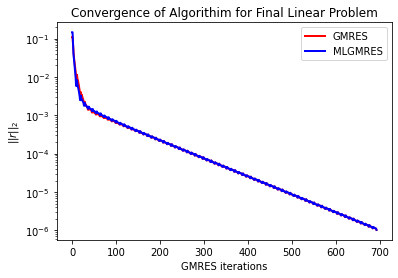

In [26]:
RHSIndex=-1
semilogy(NonML_Err_List_Full[RHSIndex],'r',label='GMRES',linewidth=2)
semilogy(trainer.IterErrList[RHSIndex],'b',label='MLGMRES',linewidth=2)
legend(loc='best')
xlabel('GMRES iterations')
ylabel('$||r||_2$')
title('Convergence of Algorithim for Final Linear Problem')

# savefig('AdvectDiff_EQ_Converg.png')

Text(0.5, 1.0, 'NN Speed Up ')

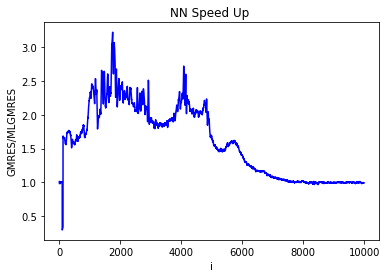

In [27]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-1]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-1]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)

plot(Ratio,'b')
xlabel('i')
ylabel('GMRES/MLGMRES')
title("NN Speed Up ")

# savetxt("SpeedupAdvectDiff.txt",Ratio)
# savefig('SpeedUp_AdvectDiff.png')